# Datathon

*import libraries*

In [1]:
# Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (RidgeCV, 
                                  LassoCV, 
                                  ElasticNetCV, 
                                  LogisticRegressionCV,
                                  LinearRegression,
                                  LogisticRegression)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, 
                             plot_confusion_matrix, 
                             roc_auc_score, 
                             plot_roc_curve, 
                             accuracy_score,
                            )
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [3]:
# import data
df = pd.read_csv('./data//final_df.csv')

In [4]:
df.head()

,Unnamed: 0,subject_id,gender,mortality_deathtime,anchor_age,icu_intime_dt,aspirin_timediff,p2y12_timediff,antiplatelet_timediff,hemo_difftime,hemo_valuenum,trop_risetime
0,0,10000980,F,0,73,2189-06-27 08:42:00,3.366667,3.366667,NaN,NaN,NaN,2189-06-27 14:18:00
1,1,10002013,F,0,53,2160-05-18 10:00:00,2.250000,2.250000,NaN,NaN,NaN,NaN
2,2,10002430,M,0,86,2129-06-13 00:43:00,4.000000,NaN,NaN,NaN,NaN,NaN
3,3,10002495,M,0,81,2141-05-22 20:18:00,11.716667,9.716667,NaN,0.716667,11.1,2141-05-22 23:05:00
4,4,10002527,M,0,50,2136-03-24 10:24:00,21.500000,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             16407 non-null  int64  
 1   subject_id             16407 non-null  int64  
 2   gender                 16407 non-null  object 
 3   mortality_deathtime    16407 non-null  int64  
 4   anchor_age             16407 non-null  int64  
 5   icu_intime_dt          16407 non-null  object 
 6   aspirin_timediff       15818 non-null  float64
 7   p2y12_timediff         3293 non-null   float64
 8   antiplatelet_timediff  22 non-null     float64
 9   hemo_difftime          5105 non-null   float64
 10  hemo_valuenum          5105 non-null   float64
 11  trop_risetime          5147 non-null   object 
dtypes: float64(5), int64(4), object(3)
memory usage: 1.5+ MB


In [6]:
# convert datetime


In [7]:
df.rename(columns={'mortality_deathtime': 'mortality'},inplace=True) 

In [8]:
df['gender'].unique()

array(['F', 'M'], dtype=object)

In [9]:
# convert gender
df['gender_bin'] = df['gender'].apply(lambda x: 1 if x is 'M' else 0)

In [10]:
df['mortality'].value_counts(normalize=True)

0    0.929055
1    0.070945
Name: mortality, dtype: float64

### Baseline model (with SMOTE)

In [12]:
X_sm = df[['anchor_age']]
y_sm = df[['mortality']]

In [13]:
# imbalanced 
y_sm.value_counts(normalize=True)

mortality
0            0.929055
1            0.070945
dtype: float64

In [14]:
# split data
Xsm_train, Xsm_test, ysm_train, ysm_test = train_test_split(X_sm, y_sm, test_size = 0.33, random_state=42, stratify=y_sm)

In [15]:
# scaling
ss = StandardScaler()

Xsm_train_sc = ss.fit_transform(Xsm_train)
Xsm_test_sc = ss.transform(Xsm_test)

In [16]:
# create synthetic data for training set
smote = SMOTE()

In [17]:
Xsmote_train, ysmote_train = smote.fit_resample(Xsm_train_sc, ysm_train)

In [18]:
smote.fit

<bound method SamplerMixin.fit of SMOTE()>

In [19]:
# balanced
ysmote_train.value_counts()

mortality
0            10212
1            10212
dtype: int64

In [20]:
# instantiate
lr = LogisticRegression()

# fit model
lr.fit(Xsmote_train, ysmote_train)

# score
lr.score(Xsmote_train, ysmote_train), lr.score(Xsm_test_sc, ysm_test)

(0.6056600078339209, 0.5850415512465375)

So the **baseline accuracy** is 0.61 (for train set), and 0.59 (for test set)

## Feature selection

### Logistic regression (with SMOTE)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             16407 non-null  int64  
 1   subject_id             16407 non-null  int64  
 2   gender                 16407 non-null  object 
 3   mortality              16407 non-null  int64  
 4   anchor_age             16407 non-null  int64  
 5   icu_intime_dt          16407 non-null  object 
 6   aspirin_timediff       15818 non-null  float64
 7   p2y12_timediff         3293 non-null   float64
 8   antiplatelet_timediff  22 non-null     float64
 9   hemo_difftime          5105 non-null   float64
 10  hemo_valuenum          5105 non-null   float64
 11  trop_risetime          5147 non-null   object 
 12  gender_bin             16407 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 1.6+ MB


In [22]:
df = df.fillna(0)

In [23]:
# from previous notebook
# drop the above columns
df.drop(columns=['Unnamed: 0','subject_id','gender','icu_intime_dt','trop_risetime'],inplace=True)

In [24]:
df.shape

(16407, 8)

In [25]:
# using (most) entire dataset 
X = df.drop(columns=['mortality'])
y = df[['mortality']]

In [26]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify=y)

In [27]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE(sampling_strategy='minority')),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])


In [28]:
# regardless of parameters, there is overfitting.
pipe_params = {
    'sampling__k_neighbors': [5, 10],   # 
    'logreg__penalty': ['l2', 'l1'],   # 
    'logreg__C': [1] # 
}

In [29]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [30]:
X_train.isnull().sum()

anchor_age               0
aspirin_timediff         0
p2y12_timediff           0
antiplatelet_timediff    0
hemo_difftime            0
hemo_valuenum            0
gender_bin               0
dtype: int64

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10992 entries, 13492 to 9663
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   anchor_age             10992 non-null  int64  
 1   aspirin_timediff       10992 non-null  float64
 2   p2y12_timediff         10992 non-null  float64
 3   antiplatelet_timediff  10992 non-null  float64
 4   hemo_difftime          10992 non-null  float64
 5   hemo_valuenum          10992 non-null  float64
 6   gender_bin             10992 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 687.0 KB


In [32]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling',
                                        SMOTE(sampling_strategy='minority')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__penalty': ['l2', 'l1'],
                         'sampling__k_neighbors': [5, 10]},
             scoring='roc_auc')

In [33]:
grid.best_params_

{'logreg__C': 1, 'logreg__penalty': 'l1', 'sampling__k_neighbors': 5}

In [34]:
grid.score(X_train, y_train), grid.score(X_test, y_test)

(0.7448539676800546, 0.7297624519644869)

Accuracy for train set is 0.74, while test set is 0.723. 

In [35]:
# getting feature importance 
lr_coef = grid.best_estimator_.named_steps['logreg'].coef_

In [36]:
coef_tot = pd.DataFrame(list(zip(X.columns,lr_coef[0])))
coef_tot.columns = ['variable','coef']
coef_tot.sort_values(by='coef',ascending=False)

,variable,coef
5,hemo_valuenum,0.793366
0,anchor_age,0.520775
3,antiplatelet_timediff,0.029590
6,gender_bin,-0.027748
2,p2y12_timediff,-0.033396
1,aspirin_timediff,-0.061185
4,hemo_difftime,-0.111736


**top 5 features**

In [37]:
coef_tot.sort_values(by='coef',ascending=False).head()

,variable,coef
5,hemo_valuenum,0.793366
0,anchor_age,0.520775
3,antiplatelet_timediff,0.029590
6,gender_bin,-0.027748
2,p2y12_timediff,-0.033396


There is ?? higher likelihood to die with one unit increase in hemo_valuenum, compared to other features

**negative features**

In [38]:
coef_tot.sort_values(by='coef').head()

,variable,coef
4,hemo_difftime,-0.111736
1,aspirin_timediff,-0.061185
2,p2y12_timediff,-0.033396
6,gender_bin,-0.027748
3,antiplatelet_timediff,0.029590


There is ?? higher likelihood in delay in hemo treatment,  compared to other features ??

In [39]:
len(coef_tot)

7

### Models

In [41]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1000, solver='saga'),
        'dt': DecisionTreeClassifier(),
        'rf': RandomForestClassifier(),
        'et': ExtraTreesClassifier(),
        'svc': SVC(probability=True),
        } 

In [42]:
def run_models(model, model_params):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('sampling', SMOTE(sampling_strategy = 'minority')),
            (model, models[model])
            ])
    
    grid = GridSearchCV(pipe, param_grid=model_params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    # metrics
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    preds = grid.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
  
    # View confusion matrix
    plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', values_format='d');
    
    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)
    
    # Calculate the specificity
    spec = tn / (tn + fp) 
    
    # print results
    print(f'Best params: {grid.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'Recall: {round(sens, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    return grid

**Logistic Regression**

Best params: {'lr__C': 0.1, 'lr__penalty': 'l1', 'sampling__k_neighbors': 3}
Training score: 0.7443
Test score: 0.7293
Recall: 0.6354
Specificity: 0.7291


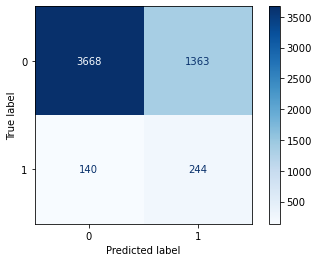

In [43]:
# logistic regression
grid_params = {
    'sampling__k_neighbors': [1,2,3],  
    'lr__penalty': ['l1', 'l2',  'elasticnet'],   
    'lr__C': [0.1, 1]  
} 

lr = run_models('lr', grid_params)

**Decision Tree Classifier**

Best params: {'dt__max_depth': 7, 'dt__min_samples_leaf': 8, 'dt__min_samples_split': 8, 'sampling__k_neighbors': 5}
Training score: 0.7849
Test score: 0.7207
Recall: 0.5234
Specificity: 0.7977


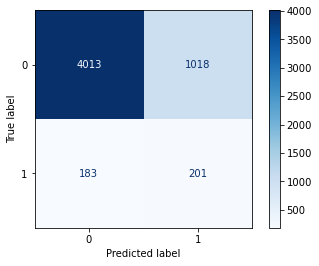

In [44]:
# decision tree classifier
grid_params = {
    'sampling__k_neighbors': [4,5,6],  
    'dt__max_depth': [7,8,9],
    'dt__min_samples_split': [7,8,9],
    'dt__min_samples_leaf': [7,8,9],
} 

dt = run_models('dt', grid_params)

**Random forest classifier**

Best params: {'rf__max_depth': 5, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 7, 'rf__n_estimators': 8, 'sampling__k_neighbors': 7}
Training score: 0.7859
Test score: 0.7495
Recall: 0.6146
Specificity: 0.7603


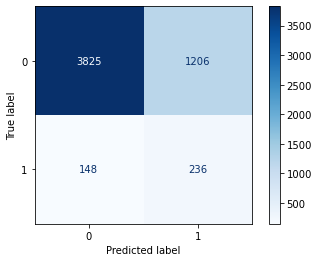

In [45]:
# random forest classifier
grid_params = {
    'sampling__k_neighbors': [7,8,9],
    'rf__n_estimators': [7,8,9],
    'rf__max_depth': [5, 8, 9],
    'rf__min_samples_split': [7,8,9],
    'rf__min_samples_leaf': [7,8,9],
} 

rf = run_models('rf', grid_params)

**Extra trees classifier**

Best params: {'et__max_depth': 6, 'et__min_samples_leaf': 15, 'et__min_samples_split': 15, 'et__n_estimators': 30, 'sampling__k_neighbors': 20}
Training score: 0.7738
Test score: 0.7536
Recall: 0.6406
Specificity: 0.7386


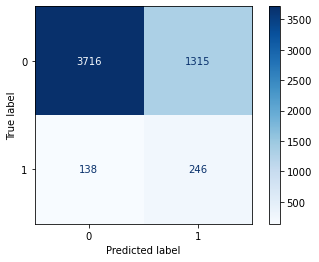

In [46]:
# extra trees classifier
grid_params = {
    'sampling__k_neighbors': [15, 20, 25],
    'et__n_estimators': [30, 35],
    'et__max_depth': [4, 5, 6],
    'et__min_samples_split': [10, 15],
    'et__min_samples_leaf': [10, 15],
} 

et = run_models('et', grid_params)

**Feature importance**

## Plot ROC-AUC 

In [48]:
def plot_all_auc(models):
    fig, ax = plt.subplots(figsize=(10,10))
    axes = {}
    for i, m in enumerate(models.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=models[m])
        
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title('ROC-AUC curve',fontsize=20)
    plt.xlabel('False Positive Rate (FPR)',fontsize=16)
    plt.ylabel('True Positive Rate (TPR)',fontsize=16)
    plt.legend()

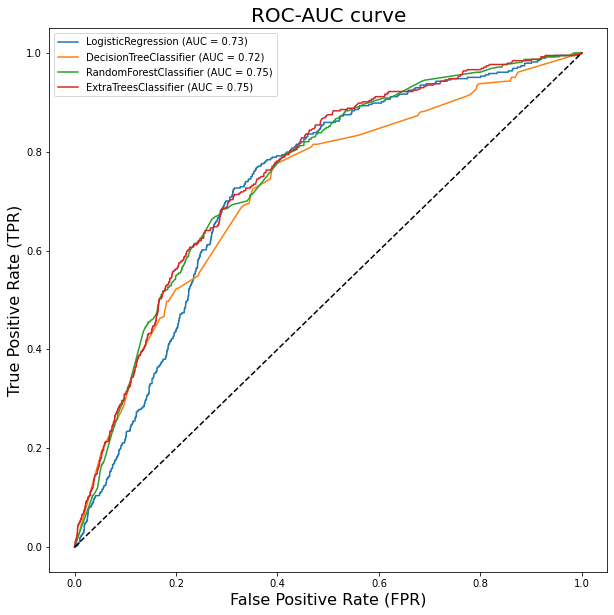

In [49]:
models_built = {
    lr : 'LogisticRegression', 
    dt : 'DecisionTreeClassifier',
    rf : 'RandomForestClassifier',
    et : 'ExtraTreesClassifier',
} 

plot_all_auc(models_built)